<a href="https://colab.research.google.com/github/subodh2708/deep-learning---tensorflow-2.0/blob/main/08_NLP_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP in Tensorflow

In [1]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data,create_tensorboard_callback,plot_loss_curves,compare_historys

--2022-09-21 07:33:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-21 07:33:39 (61.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data('nlp_getting_started.zip')


--2022-09-21 07:33:43--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.008s  

2022-09-21 07:33:43 (74.4 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
 import pandas as pd
 train_df = pd.read_csv("train.csv")
 test_df = pd.read_csv("test.csv")
 train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df_shuffled = train_df.sample(frac=1,random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
len(train_df),len(test_df)

(7613, 3263)

In [9]:
import random
random_index = random.randint(0,len(train_df)-5)
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  _,text,target = row
  print(f"target:{target}","(real disaster)" if target > 0 else  "(not a disaster)")
  print(f"Text\n {text} \n")
  print("---\n")

target:0 (not a disaster)
Text
 http://t.co/PmHMmkSPaQ -PANDEMONIUM! Playstation One PS1 Retro Classic Original Platform Platinum Rare#Deals_UK http://t.co/0gKNpy4lUA 

---

target:1 (real disaster)
Text
 #ClimateChange Eyewitness to Extreme Weather: 11 Social Media Posts that Show Just How Crazy Things A... http://t.co/czpDn9oBiT #Anarchy 

---

target:0 (not a disaster)
Text
 Ever since my Facebook #Mets meltdown after the Padres fiasco- mets are 6-0. You're welcome 

---

target:1 (real disaster)
Text
 @Jennife29916207 I was thinking about you today when I was reading about the wild fires 

---

target:0 (not a disaster)
Text
 survived the plague
floated the flood
just peeked our heads above the mud
no one's immune
deafening bells
my god will we survive ourselves? 

---



## splitting the data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_sentences, val_sentences,train_labels,val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                          train_df_shuffled['target'].to_numpy(),
                                                                          test_size = 0.1,
                                                                          random_state = 42)

## converting text into numbers

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = "lower_and_strip_punctuation",
                                    split = 'whitespace',
                                    ngrams = None,
                                    output_mode = "int",
                                    output_sequence_length = None,
                                    pad_to_max_tokens= False
                                    )

In [13]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [14]:
max_vocab_length = 10000
max_length = 15

In [15]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length)

In [16]:
text_vectorizer.adapt(train_sentences)

In [17]:
sample_sentence = "there is flood in my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [18]:
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence} \
      \n Vectorized version:\n {text_vectorizer([random_sentence])}')

Original text:
 RT skanndTyagi WIRED : Reddit will now quarantine offensive content http://t.co/H0xUNJ3C7C (http://t.co/UuEw4MJLesÛ_ Û_       
 Vectorized version:
 [[  96 4613 1568  273   38   48  417  768  226    1    1  203    0    0
     0]]


In [19]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"number of words in vocab:{len(words_in_vocab)}")
print(f"top 5 word in vocab:{top_5_words}")
print(f"bottom 5 words in vocab:{bottom_5_words}")

number of words in vocab:10000
top 5 word in vocab:['', '[UNK]', 'the', 'a', 'in']
bottom 5 words in vocab:['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating the Embedding using Embedding layer

In [20]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim = max_vocab_length,
                      output_dim = 128,
                      embeddings_initializer ='uniform',
                      input_length = max_length)
embedding

In [21]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence} \
        \n Embedded Version:")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 'By accident' they knew what was gon happen https://t.co/Ysxun5vCeh         
 Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02958946,  0.04768777, -0.03400393, ..., -0.03251727,
         -0.04964825, -0.04313029],
        [ 0.04894123,  0.00078533, -0.03229616, ..., -0.0191924 ,
         -0.02496799,  0.02836312],
        [-0.02119491, -0.0426087 , -0.04467344, ...,  0.0341885 ,
          0.04690704, -0.02843026],
        ...,
        [ 0.00062072,  0.03627955,  0.01624684, ...,  0.02118511,
          0.03840492,  0.03940528],
        [ 0.00062072,  0.03627955,  0.01624684, ...,  0.02118511,
          0.03840492,  0.03940528],
        [ 0.00062072,  0.03627955,  0.01624684, ...,  0.02118511,
          0.03840492,  0.03940528]]], dtype=float32)>

In [22]:
random_sentence ,sample_embed[0][0],sample_embed[0][0].shape

("'By accident' they knew what was gon happen https://t.co/Ysxun5vCeh",
 <tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.02958946,  0.04768777, -0.03400393, -0.01325507, -0.02147001,
        -0.04259378, -0.02276975,  0.02737737, -0.04333204,  0.01942461,
        -0.00215062,  0.02171905,  0.04207952, -0.03018889,  0.04140464,
         0.00719506, -0.02546576,  0.02432089, -0.03172188,  0.03984472,
         0.00890846,  0.01280059, -0.00280011, -0.02531856,  0.00711627,
        -0.01354867, -0.02395077,  0.02844006,  0.04764289,  0.03124012,
         0.00769288,  0.01945904, -0.0132431 ,  0.04814955, -0.00776476,
         0.02167149, -0.02480129, -0.00293545, -0.00578224,  0.04636994,
         0.01473421, -0.02961465, -0.04981012,  0.04442277,  0.02937194,
        -0.03587312,  0.03121987, -0.03827675, -0.00722156, -0.01501311,
        -0.04512681,  0.02045285,  0.01772367, -0.002002  ,  0.03696347,
        -0.01588393, -0.00779856,  0.04616672, -0.04119685,  0.0278166 ,
   

## Modelling text Dataset 

## Model 0: Getting the baseline model

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [24]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f' baseline accuracy : {baseline_score *100:.2f}%')

 baseline accuracy : 79.27%


In [25]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## creating our evaluation function for our model experiments

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_result(y_true,y_pred):
  model_accuracy = accuracy_score(y_true,y_pred)
  model_precision,model_recall,model_f1,_ = precision_recall_fscore_support(y_true,y_pred,average = 'weighted')
  model_results = {'accuracy':model_accuracy,
                   'precision':model_precision,
                   'recall':model_recall,
                   'f1':model_f1}

  return model_results


In [27]:
baseline_results = calculate_result(y_true=val_labels,
                                    y_pred = baseline_preds)
print(baseline_results)

{'accuracy': 0.7926509186351706, 'precision': 0.8111390004213173, 'recall': 0.7926509186351706, 'f1': 0.7862189758049549}


##Model 1: simple dense model

In [28]:
from helper_functions import create_tensorboard_callback

In [29]:
SAVE_DIR = 'model_logs'

In [30]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype= tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs,outputs, name= 'model_1_dense')

In [31]:
model_1.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [32]:
model_1_history= model_1.fit(x = train_sentences,
                           y= train_labels,
                           epochs = 5,
                           validation_data = (val_sentences,val_labels),
                           callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                    experiment_name = 'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20220921-073346
Epoch 1/5
215/215 [==============================] - 10s 39ms/step - loss: 0.6117 - accuracy: 0.6932 - val_loss: 0.5419 - val_accuracy: 0.7402
Epoch 2/5
215/215 [==============================] - 8s 37ms/step - loss: 0.4418 - accuracy: 0.8181 - val_loss: 0.4678 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 9s 40ms/step - loss: 0.3475 - accuracy: 0.8594 - val_loss: 0.4567 - val_accuracy: 0.7979
Epoch 4/5
215/215 [==============================] - 8s 37ms/step - loss: 0.2845 - accuracy: 0.8915 - val_loss: 0.4605 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 6s 26ms/step - loss: 0.2381 - accuracy: 0.9092 - val_loss: 0.4778 - val_accuracy: 0.7795


In [33]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4778 - accuracy: 0.7795


[0.47782590985298157, 0.7795275449752808]

In [34]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[0:10]

array([[0.46121308],
       [0.8488046 ],
       [0.9975406 ],
       [0.1505714 ],
       [0.13330835],
       [0.95317686],
       [0.92528695],
       [0.9938736 ],
       [0.9715613 ],
       [0.33917594]], dtype=float32)

In [35]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [36]:
model_1_results = calculate_result(y_true = val_labels,
                                   y_pred = model_1_preds)
model_1_results

{'accuracy': 0.7795275590551181,
 'precision': 0.7802422774076316,
 'recall': 0.7795275590551181,
 'f1': 0.7781078501550943}

In [37]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))


array([False, False, False, False])

## Visualising learned embeddings

In [38]:
word_in_vocab = text_vectorizer.get_vocabulary()
len(word_in_vocab) , words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [39]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [40]:
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape

(10000, 128)

In [41]:
import io

# Code to save trained embeddings to file - we got this from here: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [42]:
# Let's download the saved embeddings locally
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Networks

###Model 2 : LSTM

In [43]:
# Create LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(f"After embedding: {x.shape}")
# x = layers.LSTM(64, activation="tanh", return_sequences=True)(x) # use return_sequences=True if you want to stack recurrent layers 
# print(f"After LSTM cell with return_sequences=True: {x.shape}")
x = layers.LSTM(64, activation="tanh")(x)
print(f"After LSTM cell: {x.shape}")
# x = layers.Dense(64, activation="relu")(x) # optional dense layer to have on top of LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

After embedding: (None, 15, 128)
After LSTM cell: (None, 64)


In [44]:
model_2.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [45]:
history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs= 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                                                 experiment_name = "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220921-073431
Epoch 1/5
215/215 [==============================] - 10s 36ms/step - loss: 0.2306 - accuracy: 0.9126 - val_loss: 0.5446 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 7s 33ms/step - loss: 0.1555 - accuracy: 0.9425 - val_loss: 0.6192 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 8s 35ms/step - loss: 0.1263 - accuracy: 0.9510 - val_loss: 0.7867 - val_accuracy: 0.7835
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.1038 - accuracy: 0.9590 - val_loss: 0.7720 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0866 - accuracy: 0.9657 - val_loss: 0.8144 - val_accuracy: 0.7782


In [46]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10]

((762, 1), array([[6.5305233e-03],
        [9.5895791e-01],
        [9.9974030e-01],
        [2.8127670e-02],
        [7.7444315e-04],
        [9.9783343e-01],
        [8.8170278e-01],
        [9.9981010e-01],
        [9.9966025e-01],
        [3.2690433e-01]], dtype=float32))

In [47]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [48]:
model_2_results = calculate_result(y_true= val_labels,
                                   y_pred = model_2_preds)
model_2_results

{'accuracy': 0.7782152230971129,
 'precision': 0.7825342114649019,
 'recall': 0.7782152230971129,
 'f1': 0.7751716074860721}

In [49]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

In [50]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype= 'string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation= 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_3 = tf.keras.Model(inputs,outputs, name='model_3_GRU')

In [51]:
model_3.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [52]:
history_3 = model_3.fit(train_sentences,
                        train_labels,
                        epochs =5,
                        validation_data =(val_sentences, val_labels),
                        callbacks= [create_tensorboard_callback(dir_name= SAVE_DIR,
                                                                experiment_name='model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220921-073511
Epoch 1/5
215/215 [==============================] - 10s 34ms/step - loss: 0.1619 - accuracy: 0.9348 - val_loss: 0.7201 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 7s 31ms/step - loss: 0.0865 - accuracy: 0.9683 - val_loss: 0.8128 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 12s 57ms/step - loss: 0.0688 - accuracy: 0.9727 - val_loss: 1.0840 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 14s 67ms/step - loss: 0.0559 - accuracy: 0.9756 - val_loss: 1.2768 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 13s 61ms/step - loss: 0.0524 - accuracy: 0.9778 - val_loss: 1.2741 - val_accuracy: 0.7677


In [53]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[1.4540255e-03],
       [5.5124587e-01],
       [9.9997306e-01],
       [1.4041764e-01],
       [1.8678047e-05],
       [9.9990368e-01],
       [9.8626757e-01],
       [9.9999189e-01],
       [9.9995929e-01],
       [9.8308313e-01]], dtype=float32)

In [54]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [55]:
model_3_results = calculate_result(y_true= val_labels,
                                   y_pred = model_3_preds)
model_3_results

{'accuracy': 0.7677165354330708,
 'precision': 0.7681410880728078,
 'recall': 0.7677165354330708,
 'f1': 0.7662770891654436}

### Model 4: Bidirectional RNN

In [56]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences= True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_4 = tf.keras.Model(inputs,outputs,name='model_4_bidirectional')

In [57]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [58]:
model_4.compile(loss= 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [59]:
history_4 = model_4.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data = (val_sentences,val_labels),
                        callbacks = [create_tensorboard_callback(dir_name= SAVE_DIR,
                                                                 experiment_name= 'model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220921-073612
Epoch 1/5
215/215 [==============================] - 20s 49ms/step - loss: 0.1123 - accuracy: 0.9650 - val_loss: 0.9655 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 11s 50ms/step - loss: 0.0523 - accuracy: 0.9775 - val_loss: 1.1091 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 11s 50ms/step - loss: 0.0460 - accuracy: 0.9784 - val_loss: 1.2528 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 18s 84ms/step - loss: 0.0420 - accuracy: 0.9794 - val_loss: 1.4960 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 18s 84ms/step - loss: 0.0383 - accuracy: 0.9816 - val_loss: 1.5876 - val_accuracy: 0.7690


In [60]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[2.91964591e-01],
       [9.40777659e-01],
       [9.99985993e-01],
       [1.17650926e-01],
       [1.19846791e-05],
       [9.99932051e-01],
       [9.89516020e-01],
       [9.99992847e-01],
       [9.99987483e-01],
       [9.98755932e-01]], dtype=float32)

In [61]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [62]:
model_4_results = calculate_result(y_true= val_labels,
                                   y_pred = model_4_preds)
model_4_results

{'accuracy': 0.7690288713910761,
 'precision': 0.7690112053301029,
 'recall': 0.7690288713910761,
 'f1': 0.7679657243023703}

### Model 5:conv1D

In [63]:
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(['this is a test sentence']))
conv_1d = layers.Conv1D(filters = 32,
                        kernel_size = 5,
                        activation = 'relu',
                        padding = 'valid')
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

In [64]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,),dtype= tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters= 64, kernel_size=5,strides=1,activation= 'relu',padding= 'valid')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation= 'sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name= 'model_5_Conv1D')

model_5.compile(loss= 'binary_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [65]:
history_5 = model_5.fit(train_sentences,
                        train_labels,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                 'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20220921-073745
Epoch 1/5
215/215 [==============================] - 7s 26ms/step - loss: 0.1261 - accuracy: 0.9596 - val_loss: 0.8964 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0752 - accuracy: 0.9712 - val_loss: 1.0450 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0631 - accuracy: 0.9756 - val_loss: 1.0881 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0556 - accuracy: 0.9777 - val_loss: 1.1977 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 8s 39ms/step - loss: 0.0517 - accuracy: 0.9780 - val_loss: 1.2487 - val_accuracy: 0.7585


In [66]:
model_5_pred_probs=model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.3541204e-01],
       [3.6683398e-01],
       [9.9988592e-01],
       [2.1455765e-02],
       [5.3801976e-09],
       [9.8140526e-01],
       [9.1609061e-01],
       [9.9989009e-01],
       [9.9999791e-01],
       [8.4456778e-01]], dtype=float32)

In [67]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
model_5_results= calculate_result(y_true= val_labels,
                                  y_pred = model_5_preds)
model_5_results

{'accuracy': 0.7585301837270341,
 'precision': 0.7611862201281965,
 'recall': 0.7585301837270341,
 'f1': 0.7556142444864076}

## Model 6: Tensorflow Hub pretrained sentence encoder

In [69]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_sample = embed([sample_sentence,
                      "when you call the universal sentence encoder on sentence ,it turns it  into numbers "])
print(embed_sample[0][:50])

tf.Tensor(
[-0.00767769  0.03333809  0.0320662  -0.02125602  0.04300849  0.08399193
  0.02452653  0.05380183 -0.02588227 -0.00499588  0.01928363 -0.00056099
  0.01276441  0.09088546  0.0562213  -0.04887728  0.05191502 -0.04136144
 -0.01161554 -0.05452844 -0.01740017  0.0045459   0.00692502 -0.01381139
 -0.00961125 -0.03933032  0.0197613  -0.01115342 -0.03671153  0.01013187
 -0.04107149  0.03479797 -0.03814119 -0.00185953  0.01663749 -0.08907217
  0.00592126  0.04859087 -0.03741663 -0.08817419  0.00334023  0.00904682
 -0.01701778  0.06431309 -0.10647684 -0.0381299  -0.02107327 -0.02888192
 -0.03679271  0.01302323], shape=(50,), dtype=float32)


In [70]:
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = "USE")

In [71]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation= 'relu'),
    layers.Dense(1, activation = 'sigmoid',name= 'output_layer')
],name = 'model_6_USE')

model_6.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [72]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [73]:
history_6 = model_6.fit(train_sentences,
                        train_labels,
                        epochs = 5,
                        validation_data = (val_sentences, val_labels),
                        callbacks =[create_tensorboard_callback(SAVE_DIR,
                                                                'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220921-073849
Epoch 1/5
215/215 [==============================] - 10s 18ms/step - loss: 0.5025 - accuracy: 0.7898 - val_loss: 0.4496 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4137 - accuracy: 0.8161 - val_loss: 0.4462 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4006 - accuracy: 0.8228 - val_loss: 0.4317 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3921 - accuracy: 0.8260 - val_loss: 0.4253 - val_accuracy: 0.8202
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3842 - accuracy: 0.8313 - val_loss: 0.4239 - val_accuracy: 0.8123


In [74]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.21389353],
       [0.8467603 ],
       [0.9905771 ],
       [0.2242041 ],
       [0.7433803 ],
       [0.7751854 ],
       [0.9866599 ],
       [0.9855678 ],
       [0.94871366],
       [0.10167682]], dtype=float32)

In [75]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [76]:
model_6_results = calculate_result(y_true= val_labels,
                                y_pred = model_6_preds)
model_6_results

{'accuracy': 0.8123359580052494,
 'precision': 0.8126207816553097,
 'recall': 0.8123359580052494,
 'f1': 0.8115900402999853}

In [77]:
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7: TF hub pretrained USE but with 10 % of the data

In [78]:
# train_10_percent = train_df_shuffled[['text','target']].sample(frac=0.1, random_state = 42)
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()

# len(train_sentences_10_percent), len(train_labels_10_percent)

In [79]:
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [80]:
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
dtype: int64

In [81]:
# Let's build a model the same as model_6
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")                               
], name="model_7_USE")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [82]:
history_7 = model_7.fit(train_sentences_10_percent,
                        train_labels_10_percent,
                        epochs = 5, 
                        validation_data = (val_sentences , val_labels),
                        callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                 'tf_hub_sentence_encoder_10_percent_correct_split')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20220921-073916
Epoch 1/5
22/22 [==============================] - 3s 53ms/step - loss: 0.6740 - accuracy: 0.6482 - val_loss: 0.6504 - val_accuracy: 0.7625
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.6066 - accuracy: 0.8044 - val_loss: 0.5944 - val_accuracy: 0.7717
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.5310 - accuracy: 0.8161 - val_loss: 0.5410 - val_accuracy: 0.7822
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4693 - accuracy: 0.8263 - val_loss: 0.5068 - val_accuracy: 0.7795
Epoch 5/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4262 - accuracy: 0.8263 - val_loss: 0.4893 - val_accuracy: 0.7769


In [83]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.24863812],
       [0.5973534 ],
       [0.9283891 ],
       [0.35752332],
       [0.5608603 ],
       [0.69071966],
       [0.8910197 ],
       [0.8331985 ],
       [0.8501197 ],
       [0.18796644]], dtype=float32)

In [84]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [85]:
model_7_results = calculate_result(y_true = val_labels,
                                    y_pred = model_7_preds)
model_7_results

{'accuracy': 0.7769028871391076,
 'precision': 0.7771036524564976,
 'recall': 0.7769028871391076,
 'f1': 0.7757784765658782}

In [86]:
model_6_results

{'accuracy': 0.8123359580052494,
 'precision': 0.8126207816553097,
 'recall': 0.8123359580052494,
 'f1': 0.8115900402999853}

## Compare the performance of each of the model

In [95]:
all_model_results = pd.DataFrame({'baseline':baseline_results,
                                  "simple_dense": model_1_results,
                                  'lstm':model_2_results,
                                  'gru':model_3_results,
                                  'bidirectional':model_4_results,
                                  'conv1d':model_5_results,
                                  'tf_hub_use_encoder':model_6_results,
                                  'tf_hub_use_encoder_10_percent':model_7_results})

all_model_results= all_model_results.T
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.779528,0.780242,0.779528,0.778108
lstm,0.778215,0.782534,0.778215,0.775172
gru,0.767717,0.768141,0.767717,0.766277
bidirectional,0.769029,0.769011,0.769029,0.767966
conv1d,0.758530,0.761186,0.758530,0.755614
tf_hub_use_encoder,0.812336,0.812621,0.812336,0.811590
tf_hub_use_encoder_10_percent,0.776903,0.777104,0.776903,0.775778


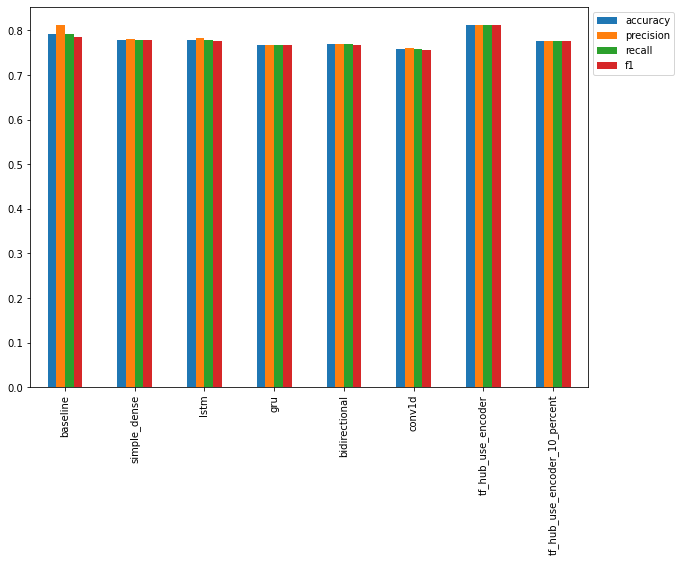

In [96]:
all_model_results.plot(kind ='bar', figsize=(10,7)).legend(bbox_to_anchor= (1.0,1.0));

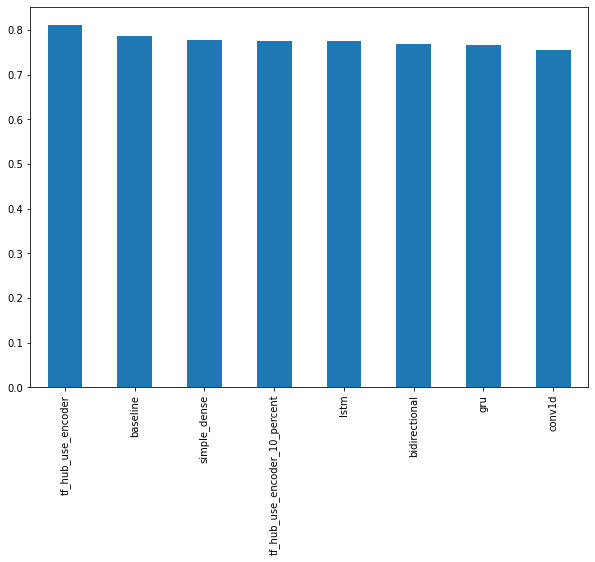

In [99]:
all_model_results.sort_values('f1',ascending= False)['f1'].plot(kind='bar', figsize= (10,7));

## Uploading our model training logs to Tensorboard.dev


In [ ]:
from traitlets.utils import descriptions
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP modelling experiments" \
  --description "comparing different model on kaggle tweet text classification" \
  --one_shot

here is the link for tensorboard model logs:https://tensorboard.dev/experiment/JyN5Q7yFQfKQ3OLURI4MOw/

In [106]:
#!tensorboard dev list


In [105]:
#!tensorboard dev delete --environment_id  JyN5Q7yFQfKQ3OLURI4MOw